## 1. Definition Problem

Book rating forecasting.

## 2. Importing Libraries

In [1]:
import numpy as np
import pandas as pd


from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer

from xgboost import XGBRegressor


import matplotlib.pyplot as plt
import seaborn as sns


from skimage import io
from langdetect import detect

from multiprocessing import Pool
import pickle

import warnings
warnings.filterwarnings('ignore')

In [2]:
sns.set()

## 3. Data Collection

In [3]:
train_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')

In [4]:
authors_data = pd.read_csv('data/authors.csv')

## 4. Data Overview

### 4.1. Looking into the training dataset

In [5]:
train_data.head()

,id,book_title,book_image_url,book_desc,book_genre,book_authors,book_format,book_pages,book_review_count,book_rating_count,book_rating
0,0,Forastera,https://images.gr-assets.com/books/1500683049l...,"Recién acabada la Segunda Guerra Mundial, una ...",Historical|Historical Fiction|Romance|Fantasy|...,Diana Gabaldon|Carmen Bordeu,Kindle Edition,768 pages,40197,668892,4.22
1,1,Writing about Magic,https://images.gr-assets.com/books/1445900480l...,Do you write fantasy fiction? This book is a r...,Language|Writing|Nonfiction,Rayne Hall,Paperback,180 pages,27,126,3.95
2,2,The Stress of Her Regard,https://images.gr-assets.com/books/1503059955l...,When Michael Crawford discovers his bride brut...,Fantasy|Horror|Paranormal|Vampires|Historical|...,Tim Powers,Paperback,470 pages,331,3626,3.79
3,3,The Horrors and Absurdities of Religion,https://images.gr-assets.com/books/1409779869l...,"A fascinating examination of ethics, religion ...",Philosophy|Religion|Nonfiction|Classics,Arthur Schopenhauer,Paperback,106 pages,28,371,3.85
4,4,Three Tales,https://images.gr-assets.com/books/1311645483l...,"First published in 1877, these three stories a...",Fiction|Short Stories|Classics|Cultural|France...,Gustave Flaubert|Roger Whitehouse|Geoffrey Wall,Paperback,110 pages,250,4331,3.72


In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 40000 non-null  int64  
 1   book_title         40000 non-null  object 
 2   book_image_url     39608 non-null  object 
 3   book_desc          40000 non-null  object 
 4   book_genre         37551 non-null  object 
 5   book_authors       40000 non-null  object 
 6   book_format        39080 non-null  object 
 7   book_pages         38141 non-null  object 
 8   book_review_count  40000 non-null  int64  
 9   book_rating_count  40000 non-null  int64  
 10  book_rating        40000 non-null  float64
dtypes: float64(1), int64(3), object(7)
memory usage: 3.4+ MB


### 4.2. Looking into the test dataset

In [7]:
test_data.head()

,id,book_title,book_image_url,book_desc,book_genre,book_authors,book_format,book_pages,book_review_count,book_rating_count
0,0,The Paper Wasp,https://i.gr-assets.com/images/S/compressed.ph...,An electrifying debut novel from the acclaimed...,Fiction|Contemporary|Thriller|Thriller|Mystery...,Lauren Acampora,Hardcover,289 pages,415,1587
1,1,The Old Success,https://i.gr-assets.com/images/S/compressed.ph...,When the body of a French woman washes up on a...,Mystery|Fiction|European Literature|British Li...,Martha Grimes,Hardcover,243 pages,409,2777
2,2,The Berlin Girl,https://i.gr-assets.com/images/S/compressed.ph...,From the bestselling author of The German Midw...,Historical|Historical Fiction|Fiction|War|Worl...,Mandy Robotham,Paperback,400 pages,270,1413
3,3,Bringing Down the Duke,https://i.gr-assets.com/images/S/compressed.ph...,One of Publishers Weekly's Most Anticipated Fa...,Romance|Historical|Historical Fiction|Romance|...,Evie Dunmore,Hardcover,356 pages,4926,32404
4,4,Horse Crazy: Girls and the Lives of Horses,https://i.gr-assets.com/images/S/compressed.ph...,Horse Crazy explores the meaning behind the lo...,Nonfiction|Psychology,Jean O'Malley Halley,Paperback,272 pages,7,11


In [8]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3020 entries, 0 to 3019
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 3020 non-null   int64 
 1   book_title         3020 non-null   object
 2   book_image_url     3020 non-null   object
 3   book_desc          3020 non-null   object
 4   book_genre         3020 non-null   object
 5   book_authors       3020 non-null   object
 6   book_format        3020 non-null   object
 7   book_pages         3020 non-null   object
 8   book_review_count  3020 non-null   int64 
 9   book_rating_count  3020 non-null   int64 
dtypes: int64(3), object(7)
memory usage: 236.1+ KB


### 4.3. Looking into the authors dataset

In [9]:
authors_data.head()

,authorid,name,workcount,fan_count,gender,image_url,about,born,died,influence,average_rate,rating_count,review_count,website,twitter,genre,original_hometown,country,latitude,longitude
0,8409092,Jason Wallace,2,13,male,https://images.gr-assets.com/authors/148926684...,Jason Wallace is related to Tolkien and a desc...,NaN,NaN,NaN,3.74,1028,175,NaN,NaN,NaN,Cheltenham,United Kingdom,51.90006,-2.07972
1,5796406,Rosan Hollak,4,0,unknown,https://s.gr-assets.com/assets/nophoto/user/u_...,NaN,NaN,NaN,NaN,3.73,15,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,8421525,Nanna Foss,6,156,female,https://images.gr-assets.com/authors/140908587...,Danish YA writer. <br /><br />I make up storie...,NaN,NaN,NaN,4.35,1172,205,http://www.nannafoss.dk,NaN,"fantasy,fiction,paranormal",NaN,NaN,NaN,NaN
3,158146,Terri Savelle Foy,23,125,female,https://images.gr-assets.com/authors/147569460...,"For years, Terri Savelle Foy’s life was averag...",NaN,NaN,NaN,4.56,1054,151,http://www.terri.com,terrisavellefoy,"religion and spirituality,self help,spirituality",NaN,NaN,NaN,NaN
4,15340731,Vishwas Nangare Patil,1,127,unknown,https://s.gr-assets.com/assets/nophoto/user/u_...,NaN,NaN,NaN,NaN,4.15,725,43,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
authors_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209517 entries, 0 to 209516
Data columns (total 20 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   authorid           209517 non-null  int64  
 1   name               209517 non-null  object 
 2   workcount          209517 non-null  int64  
 3   fan_count          209517 non-null  int64  
 4   gender             209517 non-null  object 
 5   image_url          209517 non-null  object 
 6   about              86724 non-null   object 
 7   born               31230 non-null   object 
 8   died               12488 non-null   object 
 9   influence          7882 non-null    object 
 10  average_rate       209517 non-null  float64
 11  rating_count       209517 non-null  int64  
 12  review_count       209517 non-null  int64  
 13  website            58320 non-null   object 
 14  twitter            35122 non-null   object 
 15  genre              73983 non-null   object 
 16  or

In [11]:
authors_data.drop(columns=['authorid', 'gender', 'image_url', 'about', 'born', 'died', 'influence', 'website', 'twitter',
                           'genre', 'original_hometown', 'country', 'latitude', 'longitude'], inplace=True)
authors_data.rename(columns={'name': 'author_name', 'workcount': 'author_work_count', 'fan_count': 'author_follower_count',
                             'average_rate': 'author_average_rating', 'rating_count': 'author_rating_count', 
                             'review_count': 'author_review_count'}, inplace=True)

In [12]:
authors_data.head()

,author_name,author_work_count,author_follower_count,author_average_rating,author_rating_count,author_review_count
0,Jason Wallace,2,13,3.74,1028,175
1,Rosan Hollak,4,0,3.73,15,1
2,Nanna Foss,6,156,4.35,1172,205
3,Terri Savelle Foy,23,125,4.56,1054,151
4,Vishwas Nangare Patil,1,127,4.15,725,43


## 5. Exploratory Data Analysis

### book_image_url

**Books have different image sizes.** 

In [13]:
def show_books(urls):
    plt.figure(figsize=(20, 10))
    plt.rcParams['axes.grid'] = False
    
    for idx, url in enumerate(urls):
        plt.subplot(-(-urls.shape[0] // 5), 5, idx + 1)
        
        try:
            plt.imshow(io.imread(url))
        except Exception:
            pass
        
    plt.rcParams['axes.grid'] = True

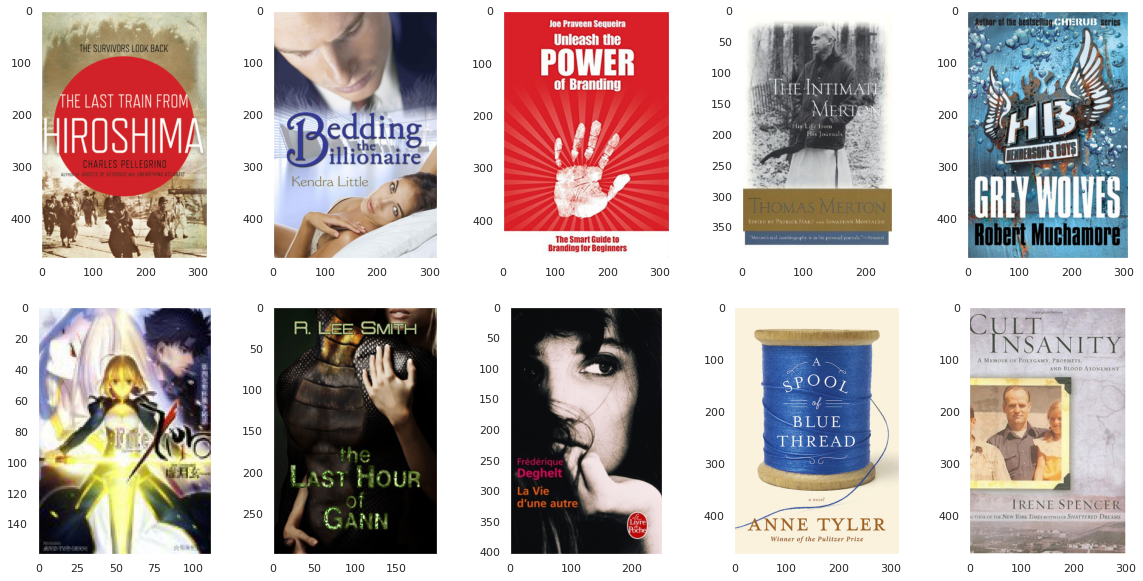

In [14]:
show_books(train_data['book_image_url'].sample(n=10).values)

### book_desc

In [15]:
def detect_lang(text):
    try:
        return detect(text)
    except Exception:
        return np.nan

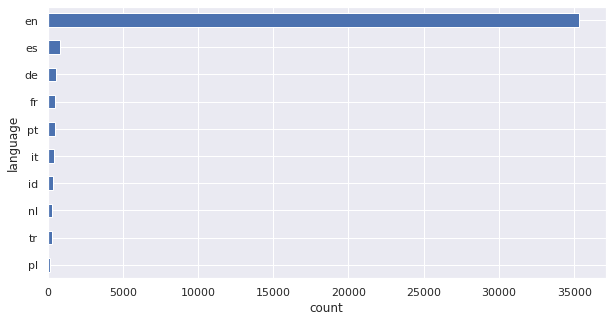

In [16]:
train_data['book_desc'].map(lambda x: detect_lang(x)).value_counts().head(10) \
                       .plot(kind='barh', figsize=(10, 5)).invert_yaxis()

plt.xlabel('count')
plt.ylabel('language');

### book_genre

**Books have duplicate genres.**

In [17]:
book_genre = train_data.loc[~train_data['book_genre'].isna(), 'book_genre']

for genre in book_genre.sample(n=10):
    print(genre)

Childrens|Middle Grade|Fiction|Realistic Fiction|Childrens|Young Adult
Romance|Paranormal Romance|Fantasy|Paranormal|Romance|Fantasy|Dragons|Fantasy|Fantasy|Urban Fantasy
Fantasy|Paranormal|Angels|Fantasy|Paranormal
Biography|Classics|Childrens
Science|Nonfiction|Health|Medicine|Medical|History
Fantasy|Young Adult|Fantasy|Fairy Tales|Fiction
Romance|Contemporary|Young Adult|Young Adult|Teen|Humor
Fantasy|Urban Fantasy|Paranormal|Vampires|Fantasy|Paranormal|Romance|Paranormal Romance|Fantasy|Paranormal|Angels
Classics|Fiction|European Literature|German Literature|Historical|Historical Fiction|War
Christian|Marriage


In [18]:
np.sum(~(book_genre.map(lambda x: len(x.split('|'))) == book_genre.map(lambda x: len(np.unique(x.split('|'))))))

19317

**Books have 854 unique genres.**

In [19]:
genres, counts = np.unique(('|'.join(book_genre.values).split('|')), return_counts=True)
genres_data = pd.DataFrame({'genre': genres, 'count': counts})

genres.shape

(854,)

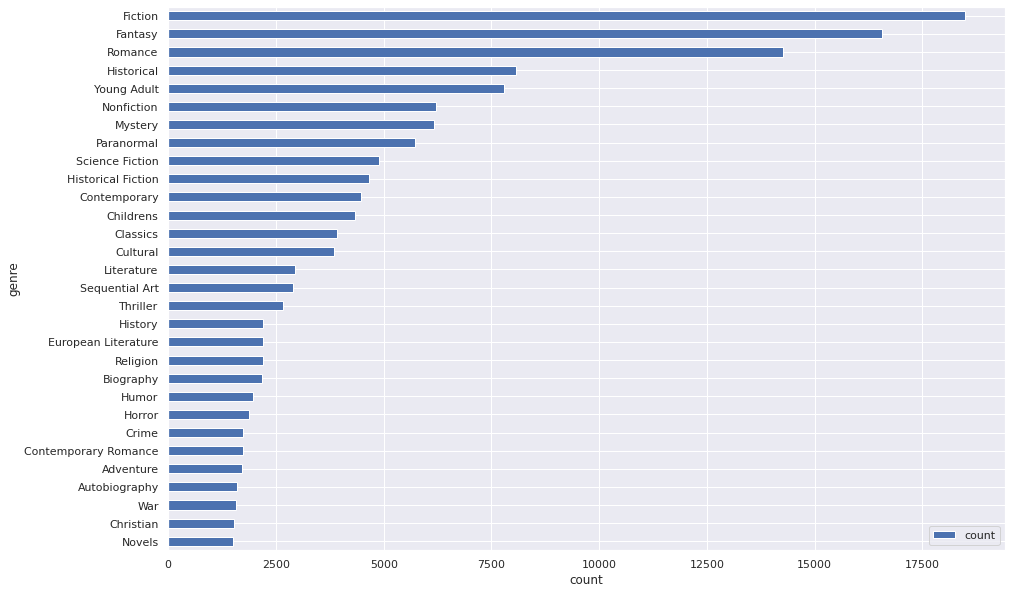

In [20]:
genres_data.set_index('genre').sort_values(by='count', ascending=False).head(30)\
           .plot(kind='barh', figsize=(15, 10)).invert_yaxis()

plt.xlabel('count');

### book_authors

**Books have duplicate authors.**

In [21]:
np.sum(~(train_data['book_authors'].map(lambda x: len(x.split('|'))) == \
         train_data['book_authors'].map(lambda x: len(np.unique(x.split('|'))))))

62

### book_format

**Books have 123 unique formats.**

In [22]:
train_data['book_format'].nunique()

123

In [23]:
train_data['book_format'].unique()

array(['Kindle Edition', 'Paperback', 'Mass Market Paperback',
       'Hardcover', nan, 'ebook', 'Nook', 'Board book', 'Bonded Leather',
       'Trade Paperback', 'Library Binding', 'Audio CD', 'Audible Audio',
       'online fiction', 'Unknown Binding', 'Interactive ebook',
       'Capa mole - 15,5 x 23 x 2cm', 'Comic', 'Audiobook',
       'Online Fiction - Complete', 'Audio Cassette', 'Broché',
       'Leather Bound', 'eBook Kindle', 'paper', 'hardcover', 'Poche',
       'audio cassette', 'Board Book', 'PDF ', 'Diary', 'Bolsillo',
       'Taschenbuch', 'Online Fiction', 'paperback', 'Other Format',
       'Mass Market', 'Perfect Paperback', 'Audio', 'Box-Set',
       'free online', 'Softcover', 'Broschiert', 'Hardcover Chapbook',
       'Klappenbroschur', 'Paperback, Kindle, Ebook, Audio', 'Innbundet',
       'Wattpad', 'Bìa mềm', 'Capa Mole', 'Hardcover Boxed Set',
       'Digital Comic', 'Box Set', 'Hardback', 'Boxed Set', 'MP3 CD',
       'softcover', 'Paperback, eBook', 'cloth', 

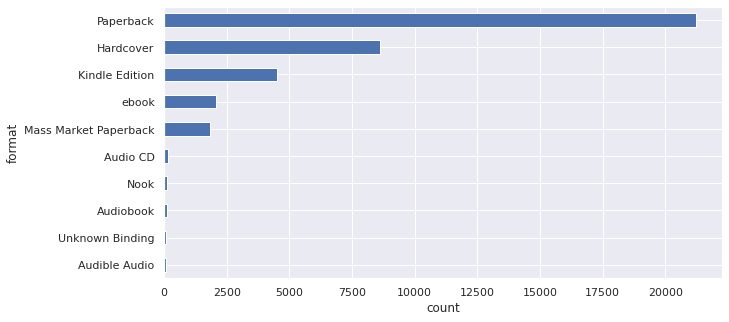

In [24]:
train_data['book_format'].value_counts().head(10).plot(kind='barh', figsize=(10, 5)).invert_yaxis()

plt.xlabel('count')
plt.ylabel('format');

In [25]:
def change_format(name):
    name = name.lower()
    if 'paperback' in name or 'hardcover' in name:
        return 'Paperbook'
    elif 'kindle' in name or 'ebook' in name:
        return 'Ebook'
    elif 'audio' in name:
        return 'Audiobook'
    else:
        return np.nan

In [26]:
train_data['book_format'] = train_data['book_format'].map(lambda x: change_format(x) if pd.notna(x) else x)

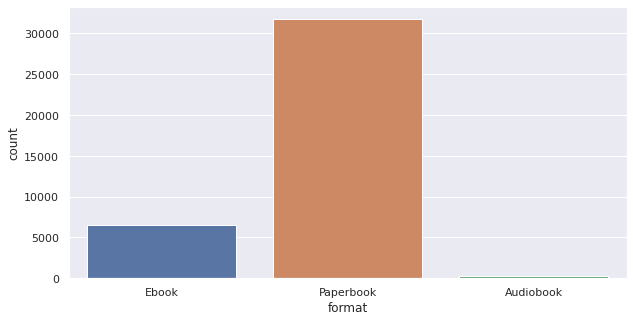

In [27]:
plt.figure(figsize=(10, 5))
sns.countplot(x='book_format', data=train_data)

plt.xlabel('format');

### book_pages

In [28]:
train_data['book_pages'] = pd.to_numeric(train_data['book_pages'].str.extract(r'(\d+)', expand=False), errors='coerce')

In [29]:
train_data[['book_pages']].describe()

,book_pages
count,38141.000000
mean,325.857843
std,237.773318
min,0.000000
25%,210.000000
50%,304.000000
75%,391.000000
max,14777.000000


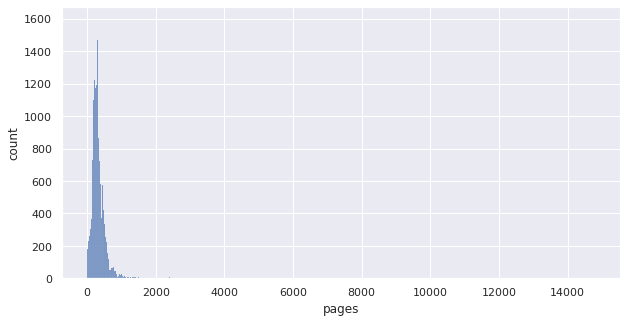

In [30]:
plt.figure(figsize=(10, 5))
sns.histplot(x='book_pages', data=train_data)

plt.xlabel('pages')
plt.ylabel('count');

### book_review_count, book_rating_count

In [31]:
train_data[['book_review_count', 'book_rating_count']].describe()

,book_review_count,book_rating_count
count,40000.000000,4.000000e+04
mean,1531.852675,3.372366e+04
std,6964.260581,1.987547e+05
min,0.000000,0.000000e+00
25%,28.000000,3.050000e+02
50%,130.000000,1.878500e+03
75%,468.000000,6.928000e+03
max,160776.000000,5.523413e+06


### author_work_count,	author_follower_count,	author_average_rating, author_rating_count, author_review_count

In [32]:
authors_data.describe()

,author_work_count,author_follower_count,author_average_rating,author_rating_count,author_review_count
count,2.095170e+05,209517.000000,209517.000000,2.095170e+05,209517.000000
mean,3.562482e+01,166.382189,3.861705,7.236301e+03,514.567171
std,2.895527e+03,3221.995738,0.459039,1.088757e+05,4541.834223
min,0.000000e+00,-18.000000,0.000000,0.000000e+00,0.000000
25%,3.000000e+00,1.000000,3.670000,6.500000e+01,8.000000
50%,8.000000e+00,6.000000,3.900000,2.970000e+02,37.000000
75%,2.100000e+01,33.000000,4.110000,1.308000e+03,162.000000
max,1.278643e+06,709826.000000,8.070000,2.451111e+07,579250.000000


## 6. Feature Engineering

### book_image_area

In [33]:
def image_size(url):
    try:
        height, width = io.imread(url).shape[:2]
        return [height, width]
    except Exception:
        return [np.nan, np.nan]

In [34]:
# with Pool(processes=50) as p:
#     pickle.dump(pd.DataFrame(p.map(image_size, train_data['book_image_url'], columns=['book_height', 'book_weight']),
#                 open('datasets/train_image_size.pickle', 'wb')))
#     pickle.dump(pd.DataFrame(p.map(image_size, test_data['book_image_url'], columns=['book_height', 'book_weight']),
#                 open('datasets/test_image_size.pickle', 'wb')))

In [35]:
with open(r'data/train_image_size.pickle', 'rb') as f:
    train_images_data = pickle.load(f).rename(columns={0: 'book_image_height', 1: 'book_image_width'})

In [36]:
train_images_data.describe()

,book_image_height,book_image_width
count,39604.000000,39604.000000
mean,426.166473,282.501060
std,80.800774,51.935354
min,1.000000,1.000000
25%,400.000000,267.000000
50%,475.000000,303.000000
75%,475.000000,316.000000
max,515.000000,500.000000


In [37]:
train_data['book_image_area'] = train_images_data['book_image_height'] * train_images_data['book_image_width']

### book_genre_count

In [38]:
top_genres = genres_data.sort_values(by='count', ascending=False)['genre'].head(30).values
train_data['book_genre_count'] = train_data['book_genre'].map(lambda x: sum([1 for genre in np.unique(x.split('|'))
                                                              if genre in top_genres]) if pd.notna(x) else x)

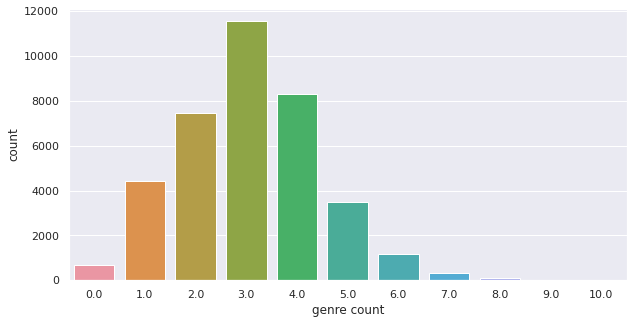

In [39]:
plt.figure(figsize=(10, 5))
sns.countplot(x='book_genre_count', data=train_data)

plt.xlabel('genre count');

### Paperbook, Ebook, Audiobook

In [40]:
train_data.dropna(subset=['book_format'], inplace=True)
train_data.reset_index(drop=True, inplace=True)
train_data = pd.concat([train_data, pd.get_dummies(train_data['book_format'])], axis=1)

### author_work_count, author_follower_count, author_average_rating, author_rating_count, author_review_count

In [41]:
authors_data.drop_duplicates('author_name', inplace=True)
authors_data.set_index('author_name', inplace=True)
authors_dict = authors_data.to_dict(orient='index')

In [42]:
def authors_info(authors):
    arr = []
    for author in authors:
        if author in authors_dict:
            arr.append(list(authors_dict[author].values()))
    
    return dict(zip(['author_work_count', 'author_follower_count', 'author_average_rating', 'author_rating_count',
                     'author_review_count'], np.array(arr).mean(axis=0).flatten()))

In [43]:
train_data = pd.concat([train_data, pd.DataFrame(train_data['book_authors']\
                                      .map(lambda x: authors_info(np.unique(x.split('|')))).tolist())], axis=1)

### Correlation matrix

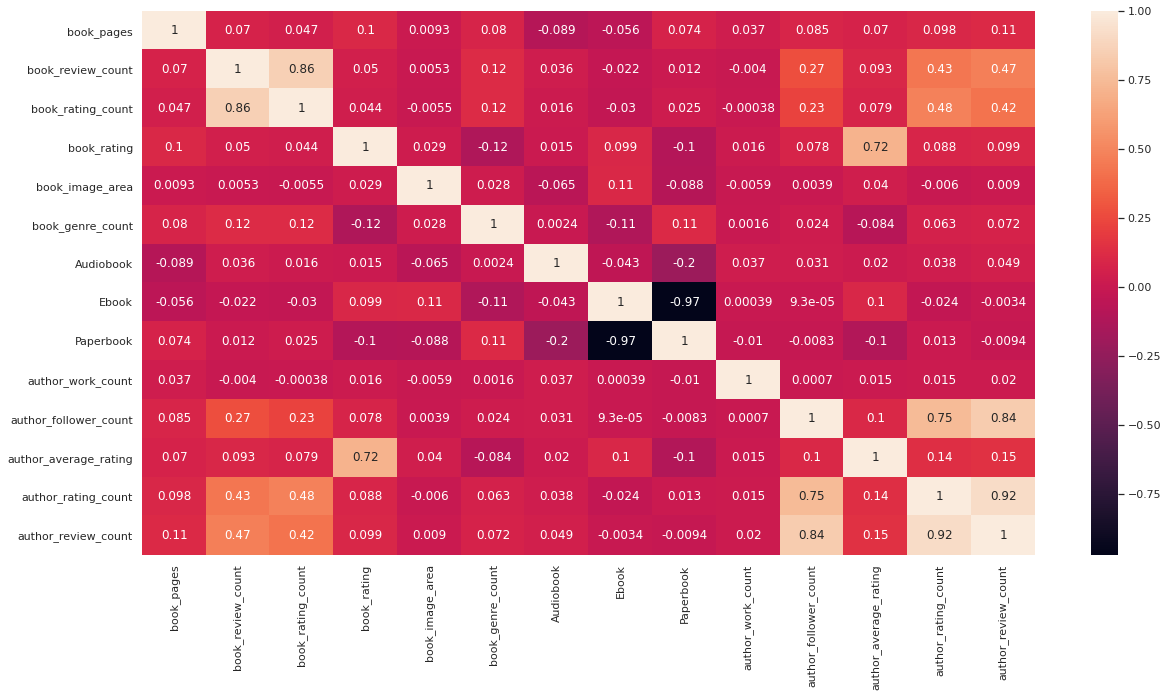

In [44]:
plt.figure(figsize=(20, 10))
sns.heatmap(train_data.drop(columns='id').corr(), annot=True);

In [45]:
train_data.drop(columns=['book_rating_count', 'Paperbook', 'Ebook', 'Audiobook', 'author_rating_count',
                         'author_follower_count'], inplace=True)

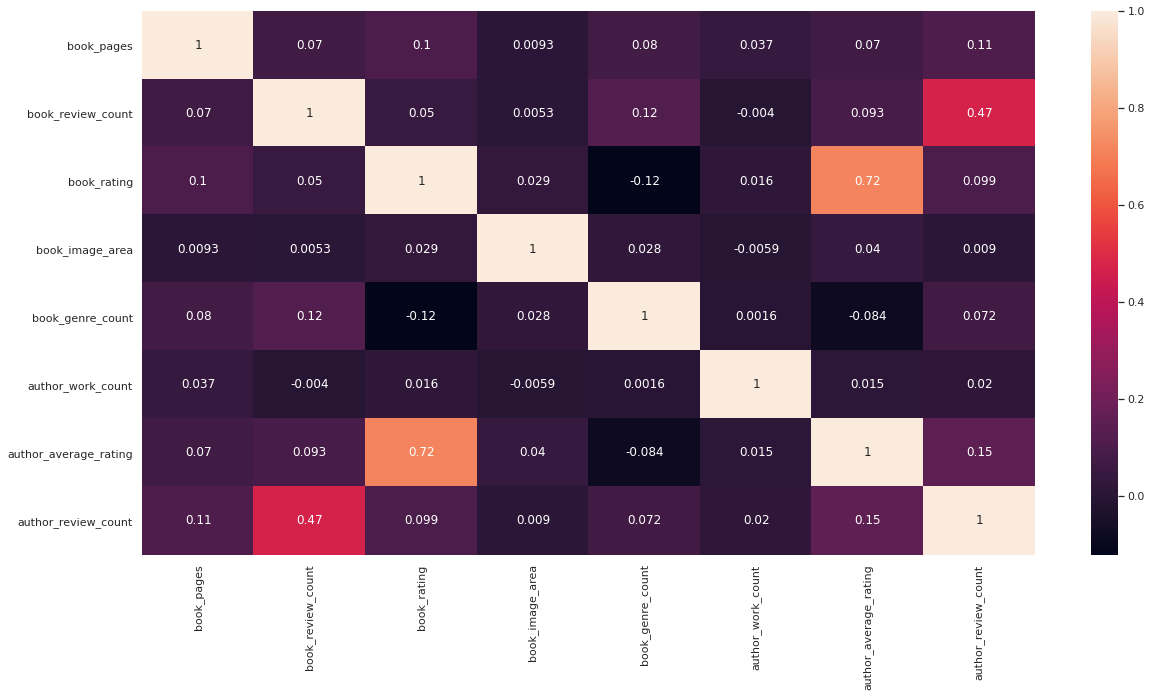

In [46]:
plt.figure(figsize=(20, 10))
sns.heatmap(train_data.drop(columns='id').corr(), annot=True);

##  Data Preparation

In [47]:
train_data.dropna(inplace=True)

In [48]:
X = train_data.drop(columns=['id', 'book_title', 'book_image_url', 'book_desc', 'book_genre', 'book_authors', 'book_format',
                             'book_rating'])
y = train_data['book_rating']

In [49]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32766 entries, 0 to 38630
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   book_pages             32766 non-null  float64
 1   book_review_count      32766 non-null  int64  
 2   book_image_area        32766 non-null  float64
 3   book_genre_count       32766 non-null  float64
 4   author_work_count      32766 non-null  float64
 5   author_average_rating  32766 non-null  float64
 6   author_review_count    32766 non-null  float64
dtypes: float64(6), int64(1)
memory usage: 2.0 MB


In [50]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

## Machine Learning

### 8.1. XGBoost

In [51]:
xgb = XGBRegressor(n_estimators=500, max_depth=5, learning_rate=0.05, n_jobs=-1)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_valid)

In [52]:
mean_squared_error(y_valid, y_pred, squared=False)

0.17820194493044492

In [53]:
cross_val_score(xgb, X, y, scoring='neg_root_mean_squared_error', cv=5).mean()

-0.18150728479232886

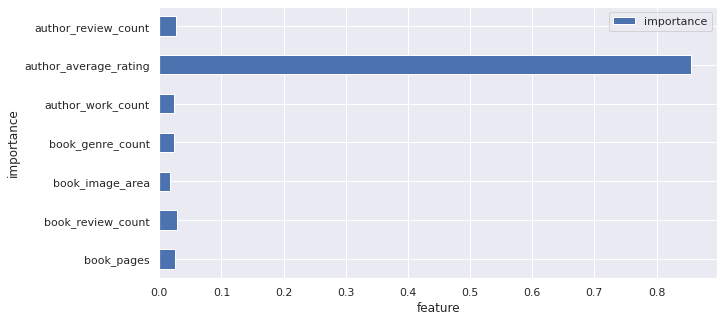

In [54]:
pd.DataFrame(xgb.feature_importances_, index=X.columns, columns=['importance']).plot(kind='barh', figsize=(10, 5))

plt.xlabel('feature')
plt.ylabel('importance');

### 8.2. Pipeline

In [55]:
medians_dict = X.median().to_dict()

In [70]:
pickle.dump(medians_dict, open('../app/objects/medians_dict.pickle', 'wb'))

In [71]:
authors_dict = authors_data.drop(columns=['author_follower_count', 'author_rating_count']).to_dict(orient='index')
pickle.dump(authors_dict, open('../app/objects/authors_dict.pickle', 'wb'))

In [56]:
def book_pages(s):
    return s.str.extract(r'(\d+)', expand=True).fillna(value=medians_dict[s.name]).astype('int')

In [57]:
# for new dataset
# def book_image_area(s):
#     arr = []
    
#     for url in s.values:
#         try:
#             height, width = io.imread(url).shape[:2]
#             arr.append(height * width)
#         except Exception:
#             arr.append(medians_dict['book_image_area'])
    
#     return pd.DataFrame(arr)

def book_image_area(df):
    return pd.DataFrame(df['book_image_height'] * df['book_image_width']).fillna(medians_dict['book_image_area'])

In [58]:
def book_review_count(s):
    return pd.DataFrame(s.fillna(value=medians_dict[s.name]))

In [59]:
def book_genre_count(s):
    top_genres = genres_data.sort_values(by='count', ascending=False)['genre'].head(30).values
    return pd.DataFrame(s.map(lambda x: sum([1 for genre in np.unique(x.split('|')) if genre in top_genres])
                              if pd.notna(x) else medians_dict[s.name]))

In [60]:
def authors_info(s):
    columns = ['author_work_count', 'author_average_rating', 'author_review_count']
    authors_dict = authors_data.drop(columns=['author_follower_count', 'author_rating_count']).to_dict(orient='index')
    
    info_arr = []
    for authors in s.map(lambda x: np.unique(x.split('|'))).values:
        arr = []
        for author in authors:
            if author in authors_dict:
                arr.append(list(authors_dict[author].values()))
        info_arr.append(np.array(arr).mean(axis=0).flatten())
    
    return pd.DataFrame(info_arr, columns=['author_work_count', 'author_average_rating', 'author_review_count']) \
             .fillna(value={'author_work_count': medians_dict['author_work_count'],
                            'author_average_rating': medians_dict['author_average_rating'],
                            'author_review_count': medians_dict['author_review_count']})

In [61]:
# for new dataset
# preprocessor = ColumnTransformer(transformers=[
#     ('book_pages', FunctionTransformer(book_pages), 'book_pages'),
#     ('book_review_count', FunctionTransformer(book_review_count), 'book_review_count'),
#     ('book_image_area', FunctionTransformer(book_image_area), 'book_image_url'),
#     ('book_genre_count', FunctionTransformer(book_genre_count), 'book_genre'),
#     ('authors_info', FunctionTransformer(authors_info), 'book_authors')])

preprocessor = ColumnTransformer(transformers=[
    ('book_pages', FunctionTransformer(book_pages), 'book_pages'),
    ('book_review_count', FunctionTransformer(book_review_count), 'book_review_count'),
    ('book_image_area', FunctionTransformer(book_image_area), ['book_image_height', 'book_image_width']),
    ('book_genre_count', FunctionTransformer(book_genre_count), 'book_genre'),
    ('authors_info', FunctionTransformer(authors_info), 'book_authors')])

In [62]:
def columns_name(df):
    return pd.DataFrame(df, columns=xgb.get_booster().feature_names)

In [63]:
pipe = Pipeline(steps=[('preprocessor', preprocessor),
                       ('dataframe', FunctionTransformer(columns_name)),
                       ('regressor', xgb)])

## 9. Submission

In [64]:
with open(r'data/test_image_size.pickle', 'rb') as f:
    test_images_data = pickle.load(f).rename(columns={0: 'book_image_height', 1: 'book_image_width'})

In [65]:
test_data = pd.concat([test_data, test_images_data], axis=1)

In [66]:
preprocessor.fit(test_data.head());

In [67]:
submission = pd.DataFrame({'id': test_data['id'], 'book_rating': pipe.predict(test_data)})
submission

,id,book_rating
0,0,3.456931
1,1,3.845304
2,2,4.275018
3,3,4.017729
4,4,4.012714
...,...,...
3015,3015,3.997902
3016,3016,3.961335
3017,3017,4.016380
3018,3018,3.883809


In [68]:
submission.to_csv('data/submission.csv', index=False)